In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr 
import equinox as eqx
import optax
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import trange

from vit import VisionTransformer

cmap = "gray_r"

In [2]:
key = jr.key(0)

n_pix = 8
c = 1
p = 1
n_heads = 4
embed_dim = 8
dropout = 0.1
hidden_dim = 32

model = VisionTransformer(
    c=c, # Channels
    p=p, # Patch size
    embed_dim=embed_dim, 
    n_layers=1,
    n_heads=n_heads,
    hidden_dim=hidden_dim,
    dropout_rate=0.1,
    output_dim=10, # Predict class  
    key=key
)

In [3]:
data = datasets.load_digits()

X = data.images.reshape(-1, 1, n_pix, n_pix)
Y = data.target[..., jnp.newaxis]

X.shape, Y.shape

((1797, 1, 8, 8), (1797, 1))

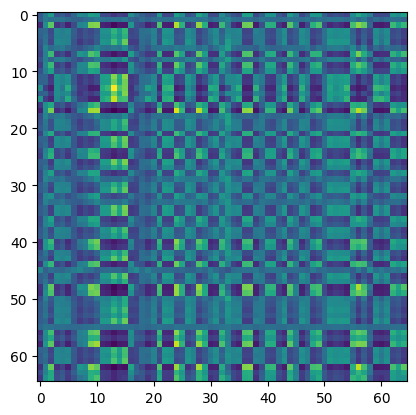

In [4]:
y, atts = model(X[0], key=key)
a = atts[0][0]

plt.imshow(a)
plt.show()

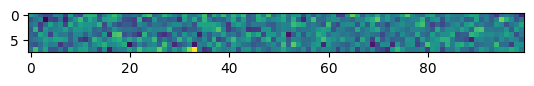

In [5]:
plt.imshow(model.embedding.position_embedding.weight.T)
plt.show()

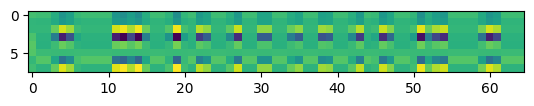

In [6]:
plt.imshow(model.embedding.token_embedding(X[0]).T)
plt.show()

In [7]:
n_epochs = 20_000
n_batch = 2000
opt = optax.adam(learning_rate=1e-4)

opt_state = opt.init(eqx.filter(model, eqx.is_array))

n_train = int(0.8 * len(X))
train_ds = TensorDataset(
    torch.as_tensor(X[:n_train]), torch.as_tensor(Y[:n_train])
)
valid_ds = TensorDataset(
    torch.as_tensor(X[n_train:]), torch.as_tensor(Y[n_train:])
)


def loss(model, keys, x, y):
    y_, _ = jax.vmap(model)(x, key=keys)
    return optax.softmax_cross_entropy_with_integer_labels(y_, y.squeeze()).mean() 


@eqx.filter_jit
def make_step(key, model, opt_state, x, y):
    keys = jr.split(key, len(x))
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, keys, x, y)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def eval(model, key, x, y):
    model = eqx.nn.inference_mode(model, True)
    keys = jr.split(key, len(x))
    loss_value = loss(model, keys, x, y)
    return loss_value


def prepare(x, y):
    return x.numpy(), y.numpy()


key_train, key_valid = jr.split(key)

losses = []
with trange(n_epochs) as bar:
    set_dl_train = DataLoader(train_ds, batch_size=n_batch)
    set_dl_valid = DataLoader(valid_ds, batch_size=n_batch)

    for _ in bar:
        Lt = 0.
        for t, (x, y) in enumerate(set_dl_train):
            key = jr.fold_in(key_train, t)
            x, y = prepare(x, y)
            model, opt_state, _Lt = make_step(key, model, opt_state, x, y)
            Lt += _Lt

        Lv = 0.
        for v, (x, y) in enumerate(set_dl_valid):
            x, y = prepare(x, y)
            _Lv = eval(model, key_valid, x, y)
            Lv += _Lv
        
        Lt = Lt.item() / (t + 1) 
        Lv = Lv.item() / (v + 1)
        losses.append((Lt, Lv))
        bar.set_postfix_str(f"{Lt=:.3E} {Lv=:.3E}")

  0%|          | 0/20000 [00:00<?, ?it/s]

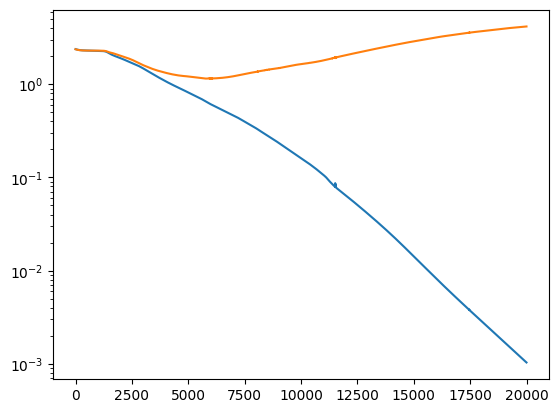

In [8]:
plt.figure()
plt.semilogy(losses)
plt.show()

In [14]:
model = eqx.nn.inference_mode(model, True)
Y_, _ = jax.vmap(model)(X)

accuracy = (Y.squeeze() == jnp.argmax(Y_, axis=1)).mean()
accuracy

Array(0.8158041, dtype=float32)

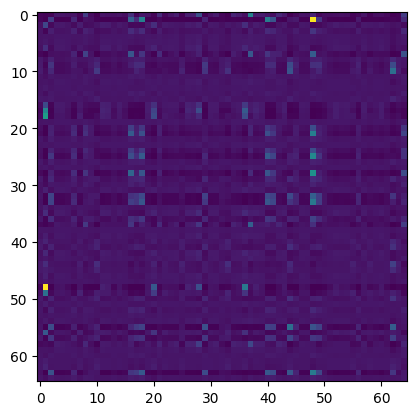

In [10]:
y, atts = model(X[0])
a = atts[0][0]

plt.imshow(a)
plt.show()

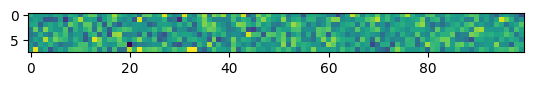

In [11]:
plt.imshow(model.embedding.position_embedding.weight.T)
plt.show()

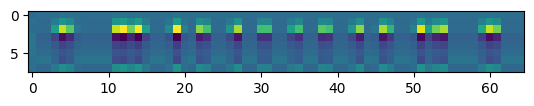

In [12]:
plt.imshow(model.embedding.token_embedding(X[0]).T)
plt.show()